# 1.1 Convolutional Neural Network Classifier - Transfer Learning

In this demo code, we will continue from 1.0 to:

<ul>
<li>Train the classifier on a subset of the Fashion MNIST data</li>
<li>Freeze the learned filters</li>
<li>Test on the hidden subset of data</li>
<li>Partially introduce the hidden subset of data</li>
<li>Explore how the intermediate representation will change</li> 
</ul>

In [2]:
#load Fashion MNIST dataset 

%matplotlib inline
import numpy as np
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#normalize the images
x_train = np.expand_dims(x_train/255.0, axis=-1)
x_test = np.expand_dims(x_test/255.0, axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [3]:
#split label 0, 1, 2 (transfer) and 3, 4, 5, 6, 7, 8, 9 (original)

x_train_original = x_train[y_train >= 3]
x_train_transfer = x_train[y_train < 3]

x_test_original = x_test[y_test >= 3]
x_test_transfer = x_test[y_test < 3]

y_train_original = y_train[y_train >= 3]
y_train_transfer = y_train[y_train < 3]

y_test_original = y_test[y_test >= 3]
y_test_transfer = y_test[y_test < 3]

print(x_train_original.shape)
print(x_test_original.shape)

print(x_train_transfer.shape)
print(x_test_transfer.shape)

print(y_train_original.shape)
print(y_test_original.shape)

print(y_train_transfer.shape)
print(y_test_transfer.shape)

(42000, 28, 28, 1)
(7000, 28, 28, 1)
(18000, 28, 28, 1)
(3000, 28, 28, 1)
(42000,)
(7000,)
(18000,)
(3000,)


In [4]:
#convert to one-hot vector encoding
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

print(y_train_one_hot.shape)
print(y_test_one_hot.shape)

y_train_original_one_hot = y_train_one_hot[y_train >= 3]
y_train_transfer_one_hot = y_train_one_hot[y_train < 3]

y_test_original_one_hot = y_test_one_hot[y_test >= 3]
y_test_transfer_one_hot = y_test_one_hot[y_test < 3]

print(y_train_original_one_hot.shape)
print(y_test_original_one_hot.shape)

print(y_train_transfer_one_hot.shape)
print(y_test_transfer_one_hot.shape)

#define the labels
class_names = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

(60000, 10)
(10000, 10)
(42000, 10)
(7000, 10)
(18000, 10)
(3000, 10)


Using TensorFlow backend.


In [5]:
#plot function for sample images

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

def plot_tile(samples):
    
    num_samples, x_dim, y_dim, _ = samples.shape
    #axes = np.sqrt(num_samples).astype(int)
    axes = (np.round(np.sqrt(num_samples))).astype(int)
    fig = plt.figure(figsize=(axes, axes))
    gs = gridspec.GridSpec(axes, axes)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(sample, cmap=plt.get_cmap('jet'), aspect='auto')

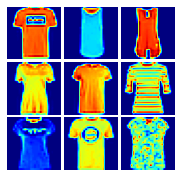

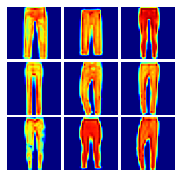

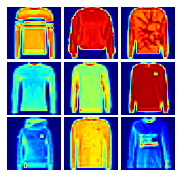

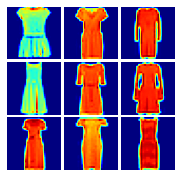

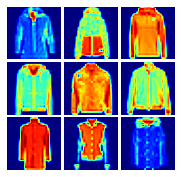

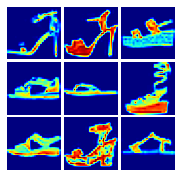

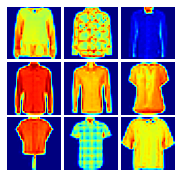

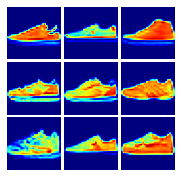

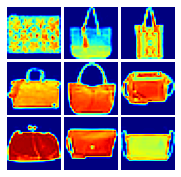

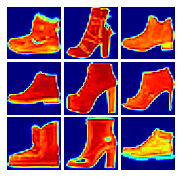

In [6]:
#visualize first 9 samples of input images based on class labels, within the training dataset

unique_labels, label_counts = np.unique(y_train, return_counts=True)

for label in unique_labels:
    x_train_perlabel = x_train[np.squeeze(y_train) == label]
    fig = plot_tile(x_train_perlabel[0:9, :, :])

In [7]:
#define a classifier with Keras 

import keras
from keras.models import Model

from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, LeakyReLU, Reshape
from keras import backend as K

from keras.optimizers import Adam
from IPython.display import clear_output
from keras.callbacks import History 

#function to view training and validation losses
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss", c = 'green')
        plt.plot(self.x, self.val_losses, label="val_loss", c = 'red')
        plt.legend()
        plt.show()

In [8]:
#define the convolutional neural network architecture

input_img = Input(shape=(x_train.shape[1], x_train.shape[1], 1)) 

_ = Conv2D(4, (3, 3), activation='linear', padding='same')(input_img)
_ = LeakyReLU(alpha=0.3)(_)
f1 = MaxPooling2D((2, 2), padding='same')(_)

_ = Conv2D(8, (4, 4), activation='linear', padding='same')(f1)
_ = LeakyReLU(alpha=0.3)(_)
f2 = MaxPooling2D((2, 2), padding='same')(_)

_ = Conv2D(16, (5, 5), activation='linear', padding='same')(f2)
_ = LeakyReLU(alpha=0.8)(_)
f3 = MaxPooling2D((2, 2), padding='same')(_)

_ = Reshape((4*4*16,))(f3)
f4 = Dense(2)(_)
out = Dense(10, activation = "softmax")(f4)

In [9]:
#set loss function, optimizer and compile

classifier = Model(input_img, out)
opt = keras.optimizers.Adam(lr=1e-3)
classifier.compile(optimizer=opt, 
                   #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, name="categorical_crossentropy"), 
                   loss="categorical_crossentropy", 
                   metrics=['accuracy'])

#get summary of architecture parameters and plot arch. diagram
classifier.summary()
from keras.utils import plot_model
plot_model(classifier, to_file='classifier.png')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 4)         40        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 4)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         520       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
________

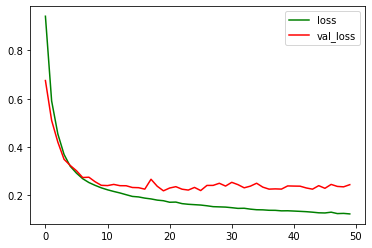

In [10]:
#train the neural network

plot_losses = PlotLosses()
classifier.fit(x_train_original, y_train_original_one_hot,        
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                callbacks=[plot_losses])

In [14]:
#get the accuracy of the trained model (on original split) on the test dataset )

test_loss, test_acc = classifier.evaluate(x_test,  y_test_one_hot, verbose=2)
print('Test accuracy:', test_acc)

test_loss_original, test_acc_original = classifier.evaluate(x_test_original,  y_test_original_one_hot, verbose=2)
print('Test accuracy - original:', test_acc_original)

test_loss_transfer, test_acc_transfer = classifier.evaluate(x_test_transfer,  y_test_transfer_one_hot, verbose=2)
print('Test accuracy - transfer:', test_acc_transfer)

#get the predictions for the test original dataset
predictions = classifier.predict(x_test)
predictions_original = classifier.predict(x_test_original)
predictions_transfer = classifier.predict(x_test_transfer)

Test accuracy: 0.6428
Test accuracy - original: 0.9182857142857143
Test accuracy - transfer: 0.0


In [13]:
#save and load the trained model

#classifier.save('classifier-original.h5')

#from keras.models import load_model
#classifier = load_model('classifier-original.h5')

In [15]:
#function to pretty plot confusion matrix (modified from SKLEARN)

import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  0   0   0  59  10   1 900   0  30   0]
 [  0   0   0 884  60   0  37   0  17   2]
 [  0   0   0  17 309   0 669   0   5   0]
 [  0   0   0 891  37   0  64   0   7   1]
 [  0   0   0  34 811   0 154   0   1   0]
 [  0   0   0   0   0 961   0  29   5   5]
 [  0   0   0  35  50   0 890   0  25   0]
 [  0   0   0   0   0  25   0 956   0  19]
 [  0   0   0   7   0  15  13   0 964   1]
 [  0   0   0   6   0   4   0  34   1 955]]
              precision    recall  f1-score   support

         Top       0.00      0.00      0.00      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.46      0.89      0.61      1000
        Coat       0.64      0.81      0.71      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.33      0.89      0.48      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.91      0.96      0.9

D:\13108\anaconda3\envs\Py36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


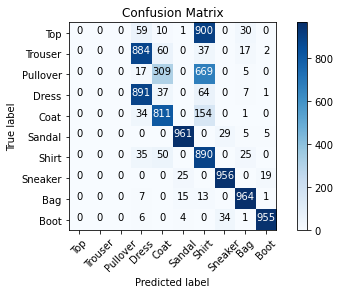

In [16]:
#print the confusion matrix and classification report

from sklearn.metrics import classification_report, confusion_matrix

matrix = confusion_matrix(y_test, predictions.argmax(axis=1))
cm1 = plot_confusion_matrix(cm=matrix, classes=class_names, title='Confusion Matrix')

#print('\nClassification Report')
print(classification_report(y_test, predictions.argmax(axis=1), target_names=class_names))

In [17]:
#functions to plot training data and the likelihood (from KERAS)

def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
    
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    
    plt.xticks(range(10))
    plt.yticks([])
    
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

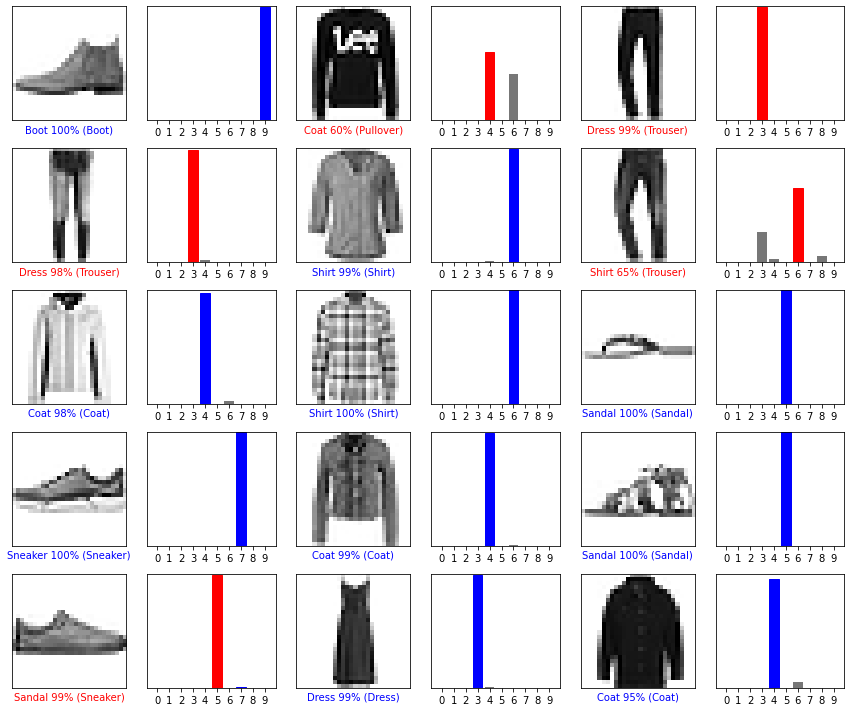

In [18]:
#plot some test images with predicted vs true labels
#correct predictions (colored blue) and incorrect predictions (colored red)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

In [19]:
#function to tile the third dimension

def collapse_channel(w):
    
    x_dim, y_dim, channel_dim = w.shape
    axes = (np.round(np.sqrt(channel_dim))).astype(int)
    w_merged = np.zeros([x_dim*axes, y_dim*axes])
    
    k = 0
    for i in range(axes):
        for j in range(axes):

            start_xidx = i*x_dim
            end_xidx = start_xidx + x_dim
            start_yidx = j*y_dim
            end_yidx = start_yidx + y_dim   

            w_merged[start_xidx:end_xidx, start_yidx:end_yidx] = w[:, :, k]
            k = k+1
            if k == channel_dim:
                break
    return w_merged

#function to get the trained kernel weights and visualize
def get_weights(model):
    for layer in model.layers:
        if 'conv2d' in layer.name:
            print(layer.name)
            w, b = layer.get_weights()
            print("Weights of layer {} {}".format(layer.name, w.shape))
            
            w_max, w_min = np.max(w), np.min(w)
            w = (w - w_min) / (w_max - w_min)
            
            plt.figure()
            for i in range(w.shape[-1]):
                axes = (np.round(np.sqrt(w.shape[-1]))).astype(int)
                ax = plt.subplot(axes, axes, i+1)
                
                #tile within each subplot
                w_i = collapse_channel(w[:, :, :, i])
                plt.imshow(w_i, cmap='jet')
                plt.xticks([])
                plt.yticks([])
                plt.axis('off')
                ax.set_aspect('equal')

conv2d_1
Weights of layer conv2d_1 (3, 3, 1, 4)
conv2d_2
Weights of layer conv2d_2 (4, 4, 4, 8)
conv2d_3
Weights of layer conv2d_3 (5, 5, 8, 16)


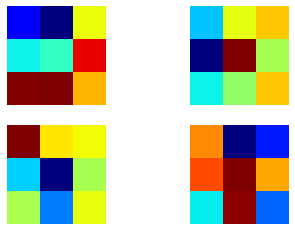

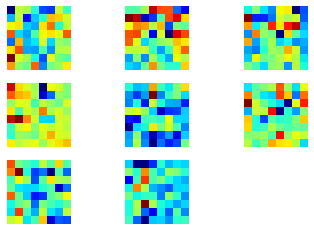

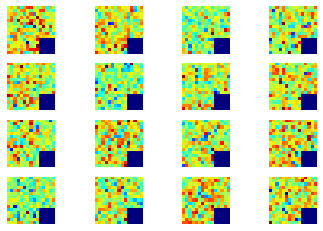

In [20]:
#get the weights for the convolutional layers

get_weights(classifier)

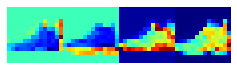

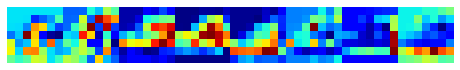

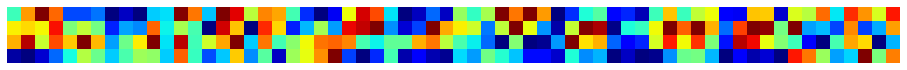

In [22]:
#visualize the activations for the convolutional layers (conv>nonlinear>pool)

test_case = 0

activations = [f1, f2, f3]
for activation in activations:
    act_classifier = Model(input_img, activation)
    act_out = act_classifier.predict(x_test[test_case:test_case+1])
    _, x_dim, y_dim, num_features = act_out.shape
    act_grid = np.zeros([x_dim, x_dim*num_features])
    
    for f_idx in range(num_features):
        feature = act_out[0, :, :, f_idx]
        feature = (feature - np.min(feature)) / (np.max(feature) - np.min(feature))
        act_grid[:, (f_idx*y_dim): (f_idx*y_dim)+y_dim] = feature
    
    plt.figure(figsize=[num_features, num_features*4])
    plt.imshow(act_grid, cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

In [23]:
#get the activations for the last layers (conv>nonlinear>pool)

act_classifier = Model(classifier.layers[0].input, classifier.layers[11].output)
act_out = act_classifier.predict(x_test)

Text(0.5, 1.0, 'Feature space')

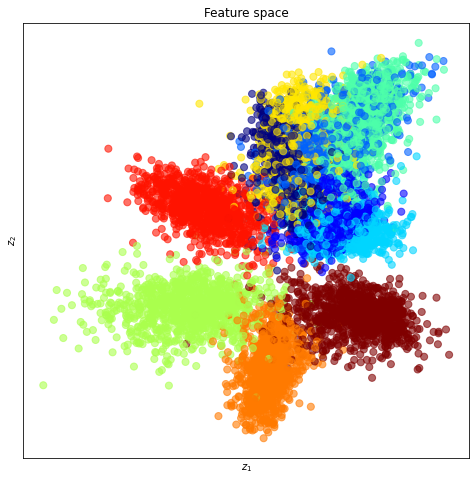

In [24]:
#plot the latent variables and color code with cum oil, gas or water
import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1,1, figsize = (8, 8))

my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

ax.scatter(act_out[:, 0], act_out[:, 1], s=50, c=cs, alpha=0.6)
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Feature space')

In [25]:
#create a transfer classifier, initialized with the trained weights, fix the weights except for the dense layers

# Check the trainable status of the individual layers
for layer in classifier.layers:
    print(layer, layer.trainable)
    
# Freeze all the layers
for layer in classifier.layers:
    layer.trainable = False
    
#Allow the last two layers to be retrained
classifier.layers[11].trainable = True
classifier.layers[12].trainable = True

# Check the trainable status of the individual layers
for layer in classifier.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000017B3E6F8240> False
<keras.layers.convolutional.Conv2D object at 0x0000017B3E6F82B0> True
<keras.layers.advanced_activations.LeakyReLU object at 0x0000017B3E6F8DD8> True
<keras.layers.pooling.MaxPooling2D object at 0x0000017B3E6F8DA0> True
<keras.layers.convolutional.Conv2D object at 0x0000017B3E6F8780> True
<keras.layers.advanced_activations.LeakyReLU object at 0x0000017B3E6F8E48> True
<keras.layers.pooling.MaxPooling2D object at 0x0000017B3E6F80F0> True
<keras.layers.convolutional.Conv2D object at 0x0000017B3E6F8C50> True
<keras.layers.advanced_activations.LeakyReLU object at 0x0000017B3DDA4C88> True
<keras.layers.pooling.MaxPooling2D object at 0x0000017B3DDA4860> True
<keras.layers.core.Reshape object at 0x0000017B3DDA4B70> True
<keras.layers.core.Dense object at 0x0000017B3DDA4828> True
<keras.layers.core.Dense object at 0x0000017B3DDA4898> True
<keras.engine.input_layer.InputLayer object at 0x0000017B3E6F8240> False
<keras.layer

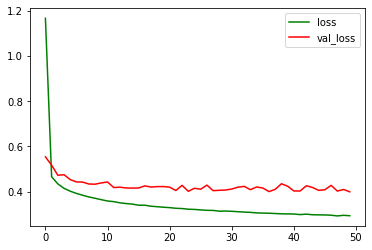

In [26]:
#retrain the classifier, but only with the transfer dataset

plot_losses = PlotLosses()
classifier.fit(x_train, y_train_one_hot,        
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                callbacks=[plot_losses])

In [27]:
#save and load the trained model

#classifier.save('classifier-transfer.h5')

#from keras.models import load_model
#classifier = load_model('classifier-transfer.h5')

In [28]:
#get the accuracy of the trained model (on original split) on the test dataset )

test_loss, test_acc = classifier.evaluate(x_test,  y_test_one_hot, verbose=2)
print('Test accuracy:', test_acc)

test_loss_original, test_acc_original = classifier.evaluate(x_test_original,  y_test_original_one_hot, verbose=2)
print('Test accuracy - original:', test_acc_original)

test_loss_transfer, test_acc_transfer = classifier.evaluate(x_test_transfer,  y_test_transfer_one_hot, verbose=2)
print('Test accuracy - transfer:', test_acc_transfer)

#get the predictions for the test original dataset
predictions = classifier.predict(x_test)
predictions_original = classifier.predict(x_test_original)
predictions_transfer = classifier.predict(x_test_transfer)

Test accuracy: 0.8649
Test accuracy - original: 0.8718571427890233
Test accuracy - transfer: 0.8486666666666667


Text(0.5, 1.0, 'Feature space')

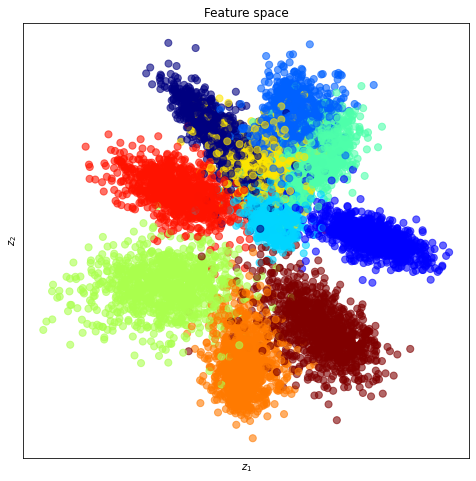

In [29]:
#get the activations for the last layers (conv>nonlinear>pool)

act_classifier = Model(classifier.layers[0].input, classifier.layers[11].output)
act_out = act_classifier.predict(x_test)

#plot the latent variables and color code with cum oil, gas or water
import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1,1, figsize = (8, 8))

my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

ax.scatter(act_out[:, 0], act_out[:, 1], s=50, c=cs, alpha=0.6)
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Feature space')